In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Tier

In [2]:
tier_df = pd.read_csv('raw_data/tier.csv')
tier_df.set_index('id', inplace=True)
print(tier_df.shape)
tier_df

(4, 1)


,tier
id,
1,GOLD
2,PLATINUM
3,EMERALD
4,DIAMOND


## Division

In [3]:
division_df = pd.read_csv('raw_data/division.csv')
division_df.set_index('id', inplace=True)
print(division_df.shape)
division_df

(4, 1)


,division
id,
1,IV
2,III
3,II
4,I


## Match

In [4]:
match_df = pd.read_csv('raw_data/match.csv')
match_df.set_index('id', inplace=True)
print(match_df.shape)
match_df.head()

(174285, 8)


,matchId,dataVersion,gameVersion,gameId,gameDuration,platformId,tierId,divisionId
id,,,,,,,,
0,EUW1_6626866687,2,13.19.534.5972,6626866687,1569,EUW1,4,4
1,EUW1_6624849036,2,13.19.534.5972,6624849036,1827,EUW1,4,4
2,EUW1_6487552891,2,13.13.518.539,6487552891,1140,EUW1,4,4
3,EUW1_6486412231,2,13.13.518.539,6486412231,1887,EUW1,4,4
4,EUW1_6626820416,2,13.19.534.5972,6626820416,1349,EUW1,4,4


In [5]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174285 entries, 0 to 174284
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   matchId       174285 non-null  object
 1   dataVersion   174285 non-null  int64 
 2   gameVersion   174284 non-null  object
 3   gameId        174285 non-null  int64 
 4   gameDuration  174285 non-null  int64 
 5   platformId    174284 non-null  object
 6   tierId        174285 non-null  int64 
 7   divisionId    174285 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 12.0+ MB


### Valores faltantes

In [6]:
match_df[match_df.isna().any(axis=1)]

,matchId,dataVersion,gameVersion,gameId,gameDuration,platformId,tierId,divisionId
id,,,,,,,,
13729,EUW1_6601449676,2,NaN,0,0,NaN,4,1


In [7]:
match_df.drop(13729, axis=0, inplace=True)

Eliminamos la unica fila (match) con datos faltantes.

In [8]:
match_df.describe()

,dataVersion,gameId,gameDuration,tierId,divisionId
count,174284.0,1.742840e+05,174284.000000,174284.000000,174284.000000
mean,2.0,6.589004e+09,1693.631320,2.652877,2.560625
std,0.0,1.399701e+08,438.236287,1.092424,1.126884
min,2.0,1.457195e+09,100.000000,1.000000,1.000000
25%,2.0,6.576502e+09,1461.000000,2.000000,2.000000
50%,2.0,6.613859e+09,1711.000000,3.000000,3.000000
75%,2.0,6.633969e+09,1960.000000,4.000000,4.000000
max,2.0,6.644169e+09,3827.000000,4.000000,4.000000


Se pudo observar: 
* Solo hay una versión de la data, la 2.0
* Existen partidas con una duración minima anormal, 100 segundos


<Axes: xlabel='count', ylabel='gameVersion'>

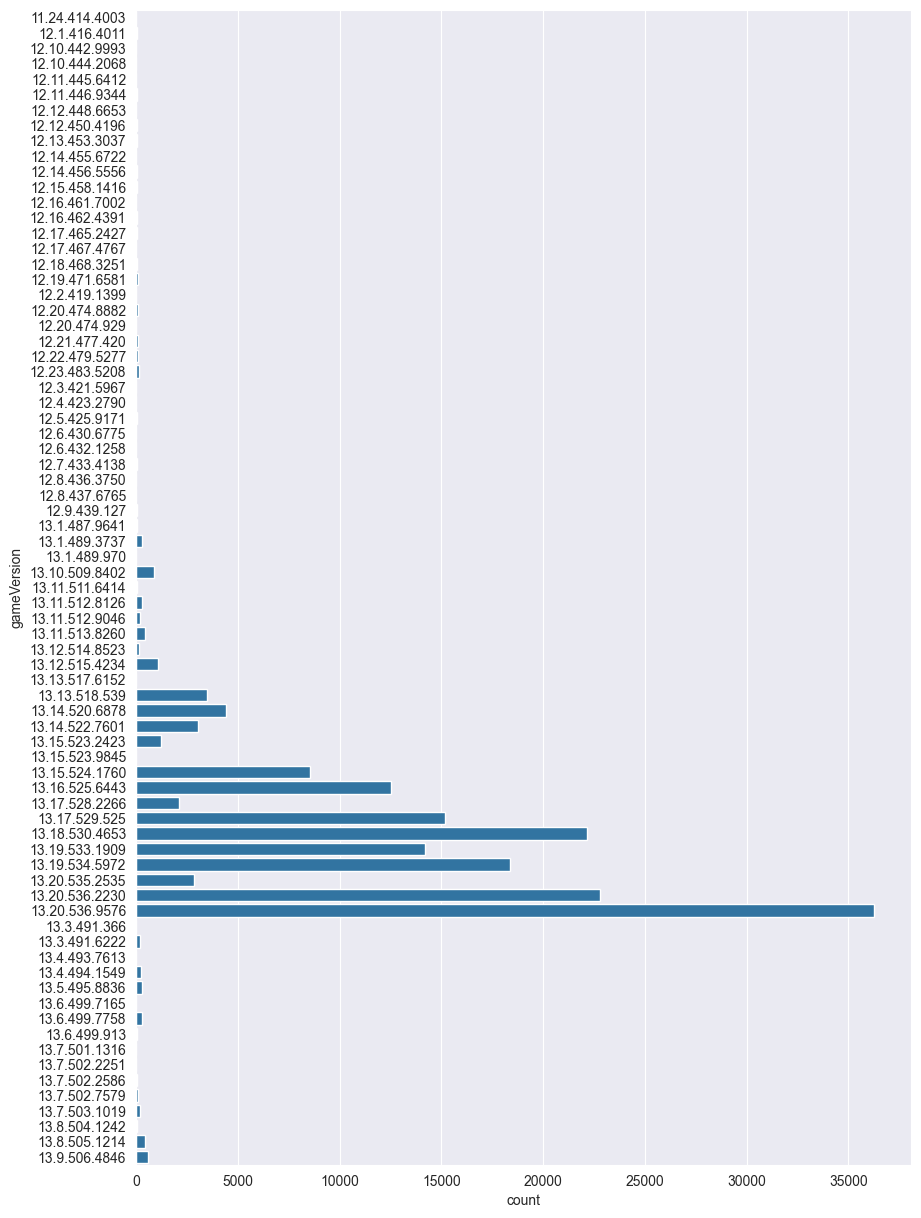

In [9]:
plt.figure(figsize=(10, 15))
sns.barplot(x='count', y='gameVersion', data=match_df.groupby('gameVersion').size().reset_index(name='count'), orient='h')

In [10]:
match_df['gameVersion'] = match_df['gameVersion'].str.extract(r'(\d+\.\d+)')

Tenemos demasiadas versiones, acoplaremos para ver si la distribución mejora.

<Axes: xlabel='count', ylabel='gameVersion'>

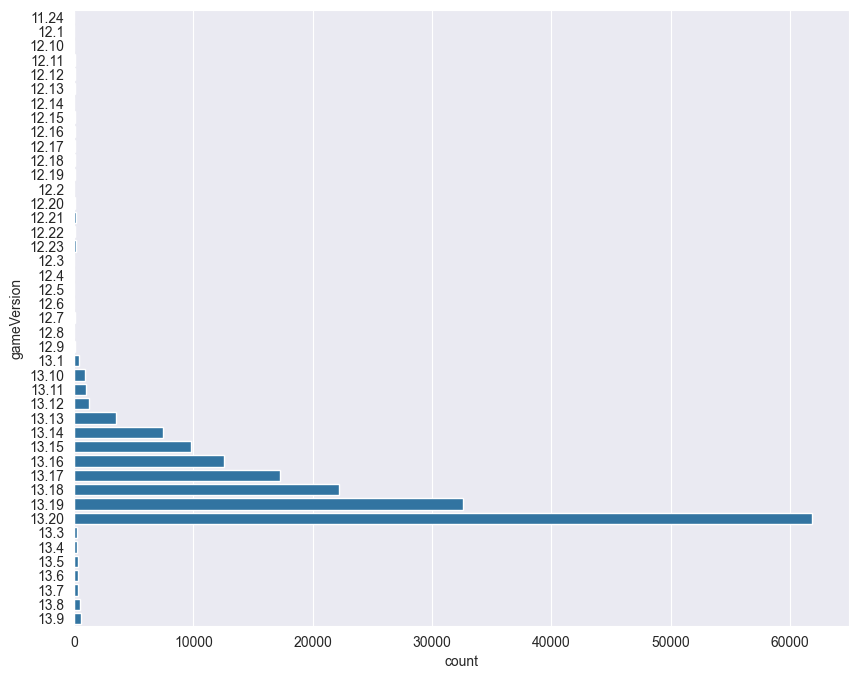

In [11]:
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='gameVersion', data=match_df.groupby('gameVersion').size().reset_index(name='count'), orient='h')

Ahora si tenemos una mejor distribución y vemos que tenemos pocos datos de versiones muy nuevas o muy antiguas, por lo cual usaremos las versiones con más representación para el modelo.

### Duración de partidas

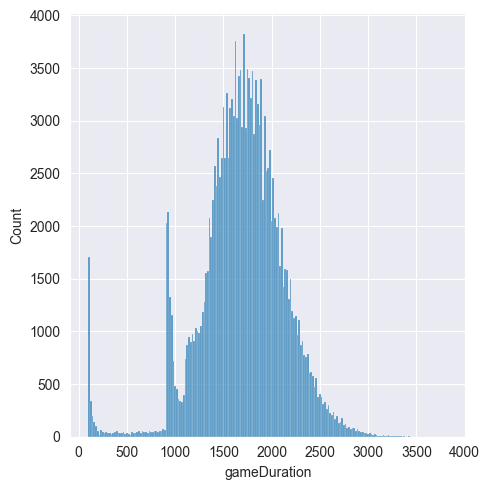

In [12]:
sns.displot(match_df['gameDuration'], kde=False)

La distribución puede ser explicada fácilmente por el sistema de rendición de League of Legends, si tienes un aliado en tu equipo que no se conectó a la partida al inicio de esta, entonces puedes realizar una votación para que tu equipo se rinda en cualquier momento; sin embargo, si tu equipo se encuentra completo al inicio de la partida, entonces tienen que pasar al menos 15 minutos (900 segundos) para realizar una votación para rendirse.
De esta forma se explican los picos anormales, por lo cual seria conveniente eliminar o clasificar por rangos la duración de partida.

In [13]:
from sklearn.cluster import KMeans

X = match_df['gameDuration'].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=4, random_state=0) 
kmeans.fit(X)
labels = kmeans.labels_
match_df['gameDurationCluster'] = labels

C:\Users\Cesar\DataspellProjects\AI-TF\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Procederemos a discretizar la duración de la partidas considerando que se formaran 4 grupos:
* Rendición por falta de un aliado
* Rendición temprana
* Juego promedio
* Juego extenso

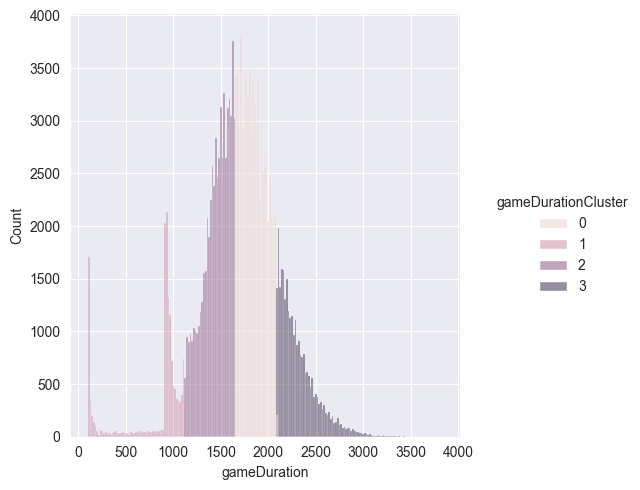

In [14]:
sns.displot(data=match_df, x='gameDuration', hue='gameDurationCluster')

In [15]:
match_df['gameDurationCluster'].replace(
    {
        0:2,
        1:4,
        2:1,
        3:3
    },
    inplace=True
)
match_df['afkEarlySurrender'] = match_df['gameDuration'] < 900

No resultó como se esperaba; sin embargo, se implemento una nueva columna para marcar el fenómeno de la rendición temprana por un aliado inactivo, se considerará establecer manualmente los valores por debajo de 900 como la agrupación 0 del cluster.

### Servidores

<Axes: xlabel='platformId', ylabel='count'>

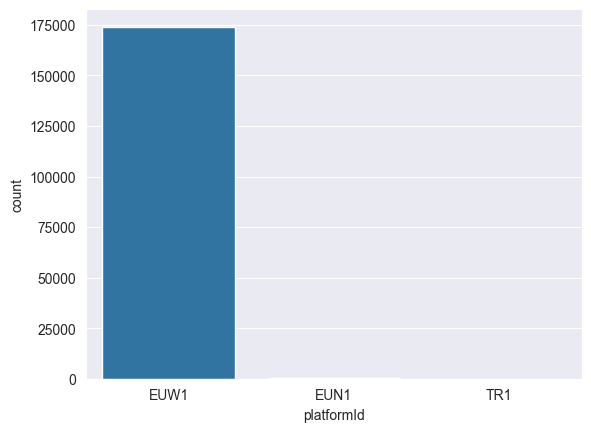

In [16]:
sns.countplot(data=match_df, x='platformId')

In [17]:
match_df = match_df[match_df['platformId']=='EUW1']

Observamos que la mayoría de las partidas del dataset pertenecen al servidor EUW1 de Europa asi que tomaremos únicamente ese servidor para evitar sesgos aunque limite las capacidades del modelo.

### Liga y división

<Axes: xlabel='tierId', ylabel='count'>

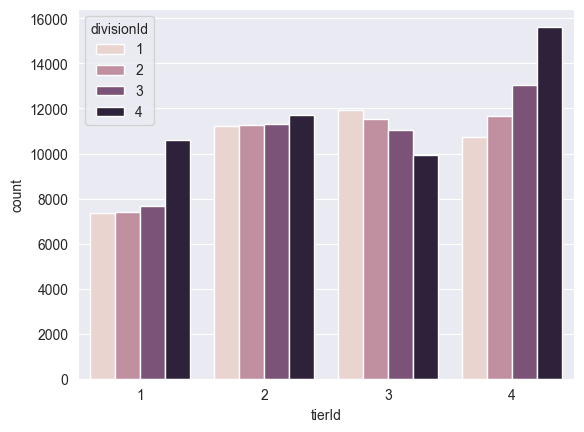

In [18]:
sns.countplot(data=match_df, x='tierId', hue='divisionId')

In [19]:
match_df[[
    'gameVersion',
    'gameDurationCluster',
    'afkEarlySurrender',
    'tierId',
    'divisionId'
]].to_csv('clean_data/match.csv', index=True)